<a href="https://colab.research.google.com/github/iciromaco/Semi3A/blob/master/L5/%E8%86%A8%E5%BC%B5%E5%8F%8E%E7%B8%AE%E3%81%A8%E8%BC%AA%E9%83%AD%E7%B7%9A%E6%8A%BD%E5%87%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ２値画像の膨張・収縮によるノイズ除去と輪郭線抽出
## **目的**

　形状解析や物体識別において、オブジェクトの輪郭あるいはシルエットは重要な特徴となる。
　対象のみが白で背景が黒、あるいはその逆であるような理想的な画像から輪郭線を得るのは容易であるが、実際の画像には、ノイズの混入があったり、取り出したい対象以外のものが写りこんでいたりする。ノイズを除去し、対象の輪郭のみを取り出すためのテクニックを学ぼう。

1. 実際の画像に対して２値の膨張・収縮処理を行い、その基本的性質を理解する。
2. 輪郭線抽出と多角形近似処理の基本的な処理プログラムについて理解する。

## **基本的な膨張・収縮処理**

- 膨張処理  
- 収縮処理  
- 膨張収縮によるノイズ除去  

　このそれぞれに
- ８近傍処理
- ４近傍処理  

があり、結果は違ってくる。

**膨張収縮によるノイズ除去**は、

- 膨張後収縮
- 収縮後膨張

のバリエーションがある。



In [0]:
import urllib.request
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
from google.colab import files

# url = "https://user-images.githubusercontent.com/5820803/81074733-6556bf80-8f24-11ea-87c8-937e09b417ac.jpg" # cross

# 処理対象画像の入力

![twoway](https://user-images.githubusercontent.com/5820803/81167986-22065a80-8fd1-11ea-8f3a-817b982afdf2.png)

入力方法を３つ用意してある。

1. URL指定
2. 即時アップロード  
3. 事前アップロード

#### **1. URL指定による画像入力**

　画像そのもののURLを指定する。サイトによっては、直リンでは画像を表示させてくれないサイトもあるので注意。

#### **2. 即時アップロード**

ペイントソフト等で作った画像を使う場合や、パソコン内にある白黒画像を処理対象にする場合は、「アップロード」を選べ。

#### **3. 事前アップロード**

　左のブラウズエリアで、事前に画像ファイルをアップロードしておく方法。

## 処理対象画像の前提

<font color=red>背景が白、対象が黒であることを前提としている。

背景が黒の場合は、**反転** にチェックを入れてセルを実行せよ。></font>

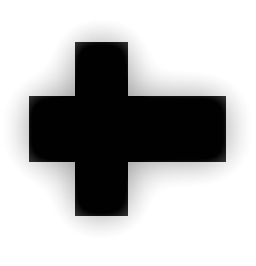

図A-1　cross.jpg


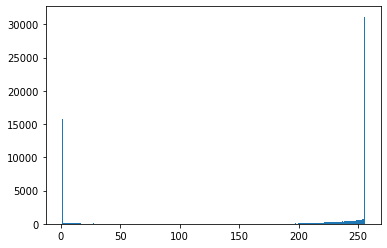

図A-2　coss.jpg のヒストグラム


In [2]:
# 処理対象画像の指定
画像入力方法 = "URL\u6307\u5B9A"  #@param ["アップロード","事前アップロード", "URL指定"]
url="https://bit.ly/3frmgPm" #@param {type:"string"}
ファイル名を入力してください="cross.png" #@param {type:"string"}
if 画像入力方法 == "アップロード":
  filename = list(files.upload())[0]
  img = cv2.imread(filename,1) # カラーで読み込み
elif 画像入力方法 == "事前アップロード":
  filename = ファイル名を入力してください
  img = cv2.imread(filename,1) # カラーで読み込み
else: # URLからのダウンロード
  img_path, header = urllib.request.urlretrieve(url)
  img = cv2.imread(img_path,1)  
  filename = ファイル名を入力してください
反転 = False #@param {type:"boolean", min:1, max:30, step:1}
gry = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # グレイスケールに変換
if 反転:
  gry = 255-gry
gry = cv2.resize(gry,(256,256)) # 256x256にリサイズ
cv2_imshow(img)
print("図A-1　cross.jpg")
hist = cv2.calcHist([gry],[0],None,[256],[0,256])
plt.hist(gry.ravel(),256,[0,256]); plt.show()
print("図A-2　coss.jpg のヒストグラム")

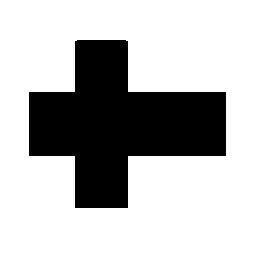

図A-3　coss.jpg を判別分析法によるしきい値 124.0 で２階調化した画像


In [3]:
# ２階調化
ret, bw = cv2.threshold(gry,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
cv2_imshow(bw)
print("図A-3　coss.jpg を判別分析法によるしきい値 {} で２階調化した画像".format(ret))

# 実験対象画像の生成

1. 上記２値画像のマージンを増やした画像
2. 45度回転した画像
3. ノイズを加えた画像

を生成する。

マージンを増やすのは、回転時と膨張処理時に図形が表示領域外に出る可能性があるため。

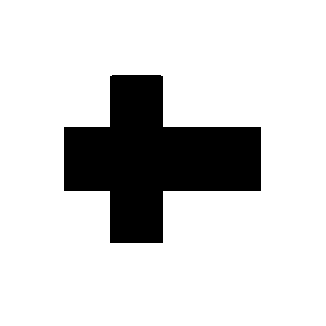

図A-4　マージンを増した２値画像


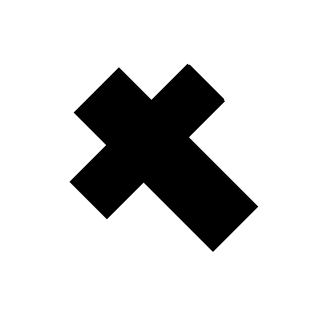

図A-5　45度回転した画像


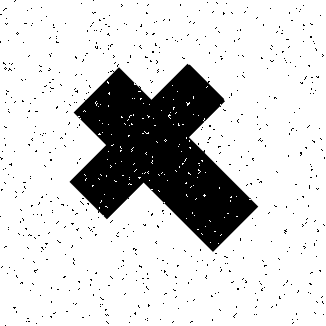

図A-6　ノイズを加えた画像


In [4]:
NNoise = 1000 # ノイズの個数
Margin = 70

def 実験用画像生成(bw):
    # 画像の高さと幅
    height = bw.shape[0]                         
    width = bw.shape[1]  

    # 余白を増やす
    timg = 255*np.ones((height+Margin,width+Margin)) # 真っ白の画像
    HM = Margin//2
    timg[HM:HM+height,HM:HM+width] = bw # 背景が白なので白黒反転

    # 中心                          
    center = (width//2+HM, height//2+HM)
    # 回転行列を作成
    rmatrix = cv2.getRotationMatrix2D(center, -45.0 , 1.0)
    #アフィン変換で４５度回転した画像を作成
    bw45 = (255-cv2.warpAffine(255-timg, rmatrix,(width+Margin,height+Margin)))

    # ノイズ画像の生成
    nbw = bw45.copy()
    pts_x = np.random.randint(0, width+Margin-1 , NNoise) # 0から(col-1)までの乱数をNNoise個作る
    pts_y = np.random.randint(0, height+Margin-1 , NNoise)
    for n in range(NNoise):
      x = pts_x[n]
      y = pts_y[n]
      for i in range(np.random.randint(0, 5)):
        rx = np.random.randint(-1, 2)
        ry = np.random.randint(-1, 2)
        x = x if x + rx < 0 or x + rx >= width+Margin else x + rx
        y = y if y + ry < 0 or y + ry >= height+Margin else y + ry
        nbw[y,x] = 255-nbw[y,x] # 反転する

    return timg,bw45,nbw

bw0,bw45,nbw = 実験用画像生成(bw)

cv2_imshow(bw0)
print("図A-4　マージンを増した２値画像")

cv2_imshow(bw45)
print("図A-5　45度回転した画像")

cv2_imshow(nbw)
print("図A-6　ノイズを加えた画像")

# 実験１　　膨張収縮によるノイズ除去

<font color=red>膨張回数と収縮回数を変えるとどうなるか試しましょう。

一番うまくノイズが消える組み合わせを報告してください。</font>

膨張と収縮には
- ４近傍処理  
- ８近傍処理

の２通りがある。ここでは４近傍処理を使ってみる。

また、ノイズ除去の手順としては、

- 膨張してから収縮（穴を閉じてからゴミを除去）
- 収縮してから膨張（上の逆）

の２通りが考えられる。

これについても、膨張→収縮のみプログラムを示す。

【課題】

　繰り返し回数を変えてみて、今回の実験に用いたノイズに対しては、何回ずつ実行するのが最適であるかを調べなさい。

【発展課題】

　膨張には４近傍処理を用い、収縮には８近傍処理を用いる、などのバリエーションを考えると、８通りのバリエーションが考えられる。

　余裕があれば、すべて試してみよ。

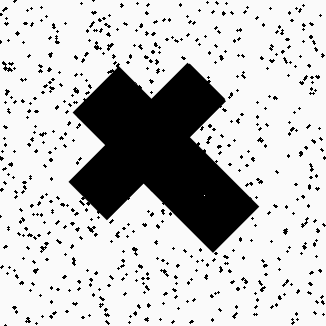

　　　　　図A-07　1回膨張後（４近傍処理）


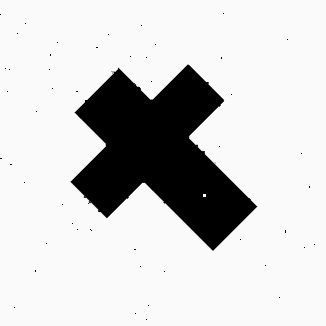

　　　　　図A-08　1回収縮後（４近傍処理）


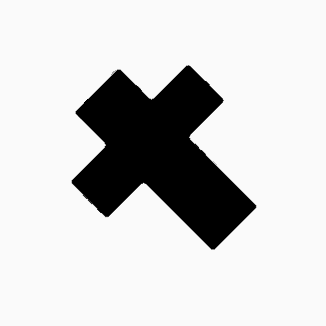

　　　　　図A-09　ミディアンフィルタ適用


In [5]:
neiborhood8 = np.ones((3,3),np.uint8)
neiborhood4 = np.array([[0, 1, 0],[1, 1, 1],[0, 1, 0]],np.uint8)
膨張回数 = 1 #@param {type:"slider", min:1, max:10, step:1}
収縮回数 = 1 #@param {type:"slider", min:1, max:10, step:1}

dilation4 = cv2.erode(nbw,neiborhood4,iterations = 膨張回数 )
cv2_imshow(250*(dilation4/255))
print("　　　　　図A-07　{}回膨張後（４近傍処理）".format(膨張回数))
erode4 = cv2.dilate(dilation4,neiborhood8,iterations = 収縮回数 )
cv2_imshow(250*(erode4/255))
print("　　　　　図A-08　{}回収縮後（４近傍処理）".format(収縮回数))
median = cv2.medianBlur(erode4.astype(np.uint8),5)
cv2_imshow(250*(median/255))
print("　　　　　図A-09　ミディアンフィルタ適用")

# 実験２　輪郭線抽出




[522]


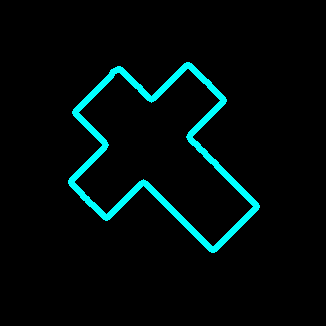

In [6]:
def getContour(img, mode=cv2.CHAIN_APPROX_NONE):
    # mode: cv2.CHAIN_APPROX_SIMPLE -> 多角形近似、cv2.CHAIN_APPROX_NONE -> 近似なし
    # 輪郭情報 主白連結成分の輪郭点列のみ返す関数
    img = 255-img
    contours, _hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, mode) # 輪郭線追跡
    cnt00 = contours[np.argmax([len(c) for c in contours])] # 最も長い輪郭
    print([len(c) for c in contours] )
    return cnt00

con = getContour(median)
h,w = median.shape[:2]
canvas = np.zeros((h,w,3),np.uint8)
cv2.drawContours(canvas, con, -1, (255,255,0), 5)
cv2_imshow(canvas)

In [7]:
print("輪郭線の画素数={}".format(len(con)))
con

輪郭線の画素数=522


array([[[186,  65]],

       [[185,  66]],

       [[184,  67]],

       ...,

       [[189,  65]],

       [[188,  65]],

       [[187,  65]]], dtype=int32)

### 輪郭線の多角形近似

[74]


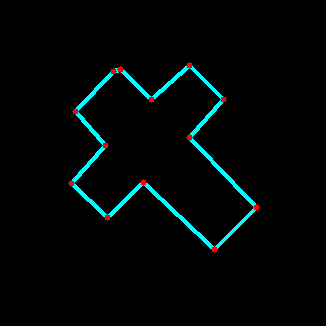

In [8]:
# 多角形近似モードで輪郭線抽出
aploy = getContour(median,mode=cv2.CHAIN_APPROX_SIMPLE)
arclen = cv2.arcLength(aploy,True) # 対象領域が閉曲線の場合、True
approx = cv2.approxPolyDP(aploy,0.005*arclen,True)
h,w = median.shape[:2]
canvas = np.zeros((h,w,3),np.uint8)
cv2.drawContours(canvas, [approx], -1, (255,255,0), 3)
cv2.drawContours(canvas, approx, -1, (0,0,255), 5)
cv2_imshow(canvas)


In [9]:
print("近似多角形の超点数={}".format(len(approx)))
approx 

近似多角形の超点数=13


array([[[113,  71]],

       [[ 75, 111]],

       [[105, 145]],

       [[ 71, 183]],

       [[107, 217]],

       [[143, 182]],

       [[214, 249]],

       [[256, 207]],

       [[189, 137]],

       [[223,  99]],

       [[189,  65]],

       [[151,  99]],

       [[120,  69]]], dtype=int32)

【課題】

　自分が用意した画像に対して、輪郭線抽出と多角形近似のプログラムを実行してみなさい。
